In [1]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting
import plotting_NII_Ha_ratios

from analysis.cardelli import *
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

In [2]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays()
AP = data_dict['AP']
HA_FLUX   = data_dict['HA_FLUX']
HB_FLUX   = data_dict['HB_FLUX']
HA_SNR    = data_dict['HA_SNR']
HB_SNR    = data_dict['HB_SNR']
NIIB_FLUX = data_dict['NIIB_FLUX']
NIIB_SNR  = data_dict['NIIB_SNR']


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

# getting rid of a source w/ atypical SFR behavior we don't understand
weird_SFR_gal = np.where(NAME0=='OIII-NB704_063543_Ha-NB816_086540')[0]

bad_sources = np.concatenate([bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal, weird_SFR_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
HA_FLUX     = HA_FLUX[ha_ii]
HB_FLUX     = HB_FLUX[ha_ii]
HA_SNR      = HA_SNR[ha_ii]
HB_SNR      = HB_SNR[ha_ii]
NIIB_FLUX   = NIIB_FLUX[ha_ii]
NIIB_SNR    = NIIB_SNR[ha_ii]
allcolsdata = allcolsdata0[ha_ii]

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs
### creating ordered FLUX arrs
### done creating ordered FLUX arrs


In [5]:
flux_3sigcutoffs_may11 = {'NB704':np.log10(5.453739e-18), 'NB711':np.log10(6.303345e-18), 
                          'NB816':np.log10(4.403077e-18), 'NB921':np.log10(4.106405e-17), 
                          'NB973':np.log10(6.790696e-17)}

In [6]:
msc = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt')

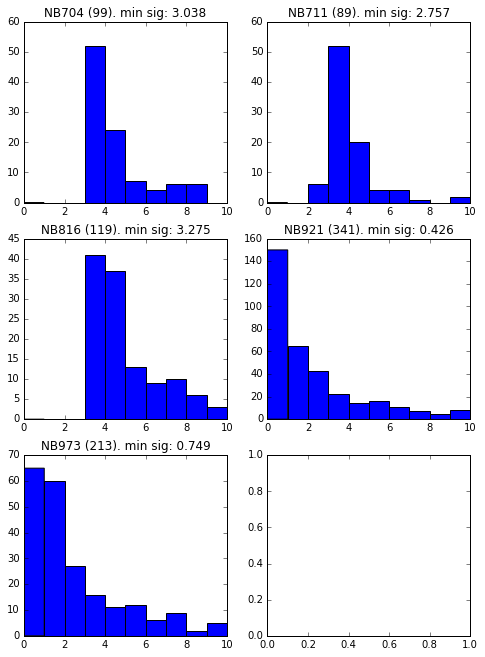

In [198]:
f, axarr = plt.subplots(3,2)
f.set_size_inches(8,11)
bins = [0,1,2,3,4,5,6,7,8,9,10]
for ax, ff in zip(np.ndarray.flatten(axarr), ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']):
    ii = np.array([x for x in range(len(msc)) if msc['filt'][x]==ff and msc['flux_sigma'][x] < 10])
    ax.hist(msc['flux_sigma'][ii], bins=bins)
    ax.set_title(ff+' ('+str(len(ii))+'). min sig: '+str(np.around(min(msc['flux_sigma'][ii]), 3)))

In [7]:
msc2 = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt')

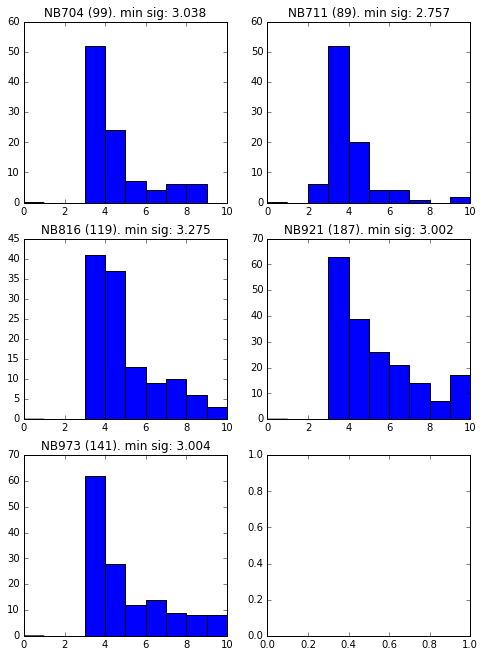

In [8]:
f, axarr = plt.subplots(3,2)
f.set_size_inches(8,11)
bins = [0,1,2,3,4,5,6,7,8,9,10]
for ax, ff in zip(np.ndarray.flatten(axarr), ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']):
    ii = np.array([x for x in range(len(msc2)) if msc2['filt'][x]==ff and msc2['flux_sigma'][x] < 10])
    ax.hist(msc2['flux_sigma'][ii], bins=bins)
    ax.set_title(ff+' ('+str(len(ii))+'). min sig: '+str(np.around(min(msc2['flux_sigma'][ii]), 3)))

In [17]:
min(msc2['flux_sigma'])

2.7570207760900001

In [14]:
len([x for x in msc2['flux_sigma'] if x < 4])

276

In [74]:
len([x for x in msc2['flux_sigma'] if x < 4.5])

360

In [75]:
len([x for x in msc2['flux_sigma'] if x < 5])

424

In [37]:
xx = np.array([np.argmin(msc2['stlr_mass']), np.where(msc['stlr_mass']==4.31)[0]])

In [38]:
msc2[xx]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
2907,Ha-NB711_104566,NB711,N/A,-10.0,4.26,3.10716123977,-17.1851863861,38.1346674257,-3.22297798813,0.149287973383,-0.022503828037,0.0531829702448,line,0.0,0.0,0.0
451,Ha-NB704_028159,NB704,N/A,-10.0,4.31,3.49827258981,-17.1965732574,37.9258370266,-3.43180838726,0.110400836647,-0.022503828037,0.0531829702448,line,0.0,0.0,0.0


In [48]:
[x for x in range(len(msc2)) if msc2['flux_sigma'][x] > 4 and msc2['stlr_mass'][x] < 5]

[419]

In [49]:
msc2[419]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
2772,Ha-NB711_096612,NB711,N/A,-10.0,4.7,4.02393829135,-17.0728988647,38.246954947,-3.11069046677,0.149287973383,-0.022503828037,0.0531829702448,line,0.0,0.0,0.0


In [51]:
[x for x in range(len(msc2)) if msc2['flux_sigma'][x] > 4 and msc2['stlr_mass'][x] < 6 and msc2['obs_sfr'][x] > -2.4]

[342]

In [52]:
msc2[342]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
1800,Ha-NB711_009037,NB711,"MMT,",9.9999,5.38,33.9190754627,-16.1471061707,39.1727476411,-2.18489777268,0.149287973383,-0.022503828037,0.0531829702448,line,0.0,0.0,0.0


In [59]:
np.where(allcolsdata['NAME']=='Ha-NB711_009037')[0]

array([342])

In [60]:
allcolsdata['NB711_FLUX'][342]

-16.147106

In [64]:
flux_3sigcutoffs['NB711']

-17.200428922051628

In [62]:
3*10**(allcolsdata['NB711_FLUX'][342] - flux_3sigcutoffs['NB711'])

33.919075462736927

In [67]:
yy = np.array([x for x in range(len(msc2)) if msc2['flux_sigma'][x] < 4 
               and msc2['zspec0'][x] > 0 and msc2['zspec0'][x] < 9])

In [69]:
msc2[yy]

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,flux_sigma,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
30,OIII-NB704_006046_Ha-NB921_020459,NB921,"MMT,",0.3977,7.81,3.38297261097,-17.1826019287,39.5631519254,-1.79449348842,0.0224733687212,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326
390,OIII-NB704_022197_Ha-NB921_043717,NB921,"merged,",0.3989,7.82,3.19485719789,-17.2074489594,39.5413925891,-1.81625282475,0.00758028529162,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326
409,OIII-NB704_023859_Ha-NB921_046168,NB921,"Keck,",0.4015,7.86,3.31423679192,-17.1915168762,39.5639853789,-1.79366003487,0.00167864939875,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326
906,OIII-NB704_072997_Ha-NB921_107294,NB921,"merged,",0.4003,7.68,3.45562203285,-17.173374176,39.5790588682,-1.77858654566,0.000790976862533,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326
2251,OIII-NB711_044949_Ha-NB973_085127,NB973,"merged,",0.4638,8.5,3.87007627811,-16.6608276367,40.2434057015,-1.1142397123,0.831922724721,-0.0561283382843,0.137963515535,line,0.164830008968,0.0650213253821,0.0659320035872
2471,OIII-NB711_069342_Ha-NB973_114595,NB973,"merged,",0.4664,7.07,3.79699237068,-16.6691074371,40.2409218021,-1.11672361169,0.531769920808,-0.022503828037,0.0531829702448,line,0.0,0.0,0.0
5070,Ha-NB921_052850,NB921,"Keck,",0.3993,7.74,3.2660333806,-17.1978797913,39.5519890842,-1.80565632963,0.00399871683872,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326
5241,Ha-NB921_063859,NB921,"Keck,",0.4007,7.89,3.96065100115,-17.1141338348,39.639323222,-1.7183221918,0.000222366019839,-0.261537079891,0.82615265861,ratio,0.287908583314,0.113572751668,0.115163433326
5946,Ha-NB921_114025,NB921,"Keck,",0.4059,7.84,3.21025845011,-17.2053604126,39.5613236438,-1.79632177,0.0653179444294,-0.022503828037,0.0531829702448,line,0.287908583314,0.113572751668,0.115163433326


In [72]:
max(msc2['flux_sigma'])

504.18343062700001